In [1]:
!mkdir DG_1D_Data

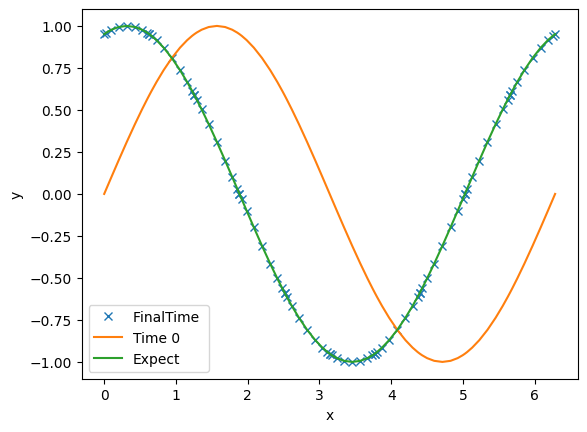

In [8]:
import numpy as np
from scipy.special import gamma
from scipy.sparse import csr_matrix, identity, find
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
def sub2ind(sz, row, col):
    n_rows = sz[0]
    return [n_rows * c + r for r, c in zip(row, col)]
def JacobiP(x, alpha, beta, N):
    '''
    Calculates the value of jacobi polynomial of type alpha, beta at points x 
    for  order N.
    x: Numpy array
    '''
    xp = x.reshape(1, -1)
    n = xp.shape[1]
    PL = np.zeros((N+ 1, n))

    gamma0 = np.power(2, alpha + beta + 1)/(alpha + beta + 1) *gamma(alpha + 1) * gamma(beta + 1)/gamma(alpha + beta + 1)   
    PL[0, :] = 1.0/np.sqrt(gamma0)
    if N == 0:
        return PL.T

    gamma1 = (alpha + 1)*(beta + 1)/(alpha + beta +3)* gamma0

    PL[1, :] = ((alpha + beta +  2) * xp/2 + (alpha - beta)/2)/np.sqrt(gamma1)

    if N == 1:
        return PL[N, :]
    
    aold = 2/(2 + alpha + beta) * np.sqrt((alpha + 1) *(beta + 1)/(alpha + beta + 3))
    for i in range(N - 1):
        h1 = 2*(i + 1) + alpha + beta
        anew = 2/(h1 + 2) * np.sqrt((i + 2) * (i+2 + alpha + beta) * (i + 2 + alpha) *(i + 2 + beta)/(h1 + 1)/(h1 + 3))
        bnew = -(alpha ** 2 - beta**2)/h1/(h1 + 2)
        PL[i + 2, : ] = 1/(anew) *(-aold * PL[i, :] + (xp - bnew) *PL[i + 1, :])
        aold = anew
    return PL[N, :]

def JacobiGQ(alpha, beta, N):
    '''
    Computes the Nth order Guass Quadrature points(x) and the 
    associated weights(w), associated with the Jacobi polynomial of type (alpha, beta)
    '''
    if N == 0:
        zer = (alpha - beta)/(alpha + beta + 2)
        wt = 2
        return np.array([zer]), np.array([wt])
    

    J = np.zeros((N + 1, N + 1))
    brr = np.array(range(1, N + 1))
    h1 = 2 * np.array(range(N  + 1)) + alpha + beta
    J = np.diag(-1/2 * (alpha ** 2 - beta ** 2)/(h1 + 2)/h1) + np.diag(
        2/(h1[:N]  + 2) * np.sqrt(brr * (brr  + alpha + beta )*(brr + alpha) * (brr + beta)/(h1[:N] + 1)/(h1[:N] + 3)), 1
        ) 
    eps = 1e-5
    if alpha + beta < 10 * eps:
     
        J[0, 0] = 0
    J = J + J.T

    D, V = np.linalg.eig(J)
    x = D
    w = np.power(V[0, :].T, 2) * (2**(alpha + beta + 1))/(alpha + beta + 1) * gamma(alpha  + 1) * gamma(beta + 1)/gamma(alpha + beta + 1)
    return x, w


def JacobiGL(alpha, beta, N):
    '''
    Computes the Nth order Gauss Lobato quadrature points(x), associated 
    with the Jacobi polynomial of type (alpha, beta)
    '''
    x = np.zeros((N + 1, 1))
    if N == 1:
        return np.array([-1, 1])
    xint, _ = JacobiGQ(alpha + 1, beta + 1, N - 2)
    ind = xint.argsort(axis = None)
    xint = xint[ind]
    x = np.concatenate(([-1], xint, [1]))

    return x

def MeshGen1D(xmin, xmax, K):
    '''
    Function to generate mesh with K elements which are equidistant
    '''
    Nv = K + 1
    VX = np.array(range(Nv), dtype = np.float128)
    for i in range(Nv):
        VX[i] = (xmax - xmin) *(i)/(Nv - 1) + xmin
    EToV = np.zeros((K, 2))
    for k in range(K):
        EToV[k, 0] = k
        EToV[k, 1] = k + 1
    return Nv, VX, K, EToV



def Vandermonde1D(N, r):
    '''
    Function to calculate the vandermonde martrix
    V_{ij} = phi_j(r_i)
    '''
    n = max(r.shape)
    V1D = np.zeros((n, N + 1))
    for j in range(N + 1):
        V1D[:, j] = JacobiP(r, 0, 0,j ).reshape((n, ))
    return V1D

def GradJacobiP(r, alpha, beta, N):
    '''
    Function to calculate the derivative of the jacobi polynomial
    of type (alpha, beta) at points r for order N and returns 
    '''
    r = r.reshape(-1, 1)
    dP = np.zeros(r.shape)
    if N == 0:
        dP[:, :] = 0.0
    else:
        dP = np.sqrt(N*(N + alpha + beta + 1)) * JacobiP(r, alpha + 1, beta + 1, N  - 1)

    return dP

def GradVandermonde1D(N, r):
    '''
    Initialize the gradient of the modal basis (i) at (r) at order N
    '''
    n = max(r.shape)
    DVr = np.zeros((n, N+ 1))
    for i in range(N + 1):
        DVr[:, i ] = GradJacobiP(r, 0, 0, i).reshape((n,))
    return DVr
    

def Dmatrix1D(N, r, V):
    '''
    Function to calculate the differentiation matrix on the interval, 
    evaluated at (r) at order N
    '''
    Vr = GradVandermonde1D(N, r)
    Dr = Vr @ np.linalg.pinv(V)
    return Dr


def Lift1D():
    '''
    Compute surface integral term in dg-formulation
    '''
    global Np, Nfaces, Nfp
    global V
    Emat = np.zeros((Np, Nfaces * Nfp))

    Emat[0, 0] = 1.0
    Emat[Np -1, 1] = 1.0

    Lift = V@(V.T @ Emat)
    return Lift





def GeometricFactors1D(x, Dr):
    '''
    Computes the metric elements for the local mappings
    of the 1D elements
    '''
    xr = Dr@x
    J = xr
    rx = 1/J
    return rx, J




def Normals1D():
    global Nfp, Nfaces, K
    nx = np.zeros((Nfp*Nfaces, K))
    nx[0, :] = -1.0
    nx[1, :] = 1.0
    return nx






def Connect1D(EToV):
    '''
    Build Global connectivity arrays for 1D grid based on standard
    EToV input array from grid generator
    '''
    global Nfaces
    K = EToV.shape[0]
    TotalFaces = Nfaces*K
    Nv = K + 1
    vn = np.array([0, 1])
    
    sk = 1
    rows = []
    cols = []
    sk = 0
    for k in range(K):
        for face in range(Nfaces):
            rows.append(sk)
            cols.append(EToV[k, vn[face]])
            sk += 1
    data = [1]*len(cols)
    SpFToV = csr_matrix((data, (rows, cols)), shape = (TotalFaces, Nv))
   
    SpFToF = SpFToV@(SpFToV.T) - identity(TotalFaces)
    
    faces1 , faces2, _ = find(SpFToF == 1)
    element1 = faces1//Nfaces 
    face1    = faces1%Nfaces 
    element2 = faces2//Nfaces
    face2    = faces2 % Nfaces
    ind = sub2ind([K, Nfaces], element1, face1)
    ind = np.array(ind)
    EToE = np.array(range(K)).reshape(-1, 1)@np.ones((1, Nfaces))
    EToF = np.ones((K, 1))@np.array(range(Nfaces)).reshape(1, -1)
    EToE[ind%K, ind//K] = element2
    EToF[ind%K, ind//K] = face2
    return EToE, EToF


def BuildMaps1D():
    global K, Np, Nfaces, Nfp, NODETOL
    global EToE, EToV, EToF
    global Fmask
    global x
    

    nodeids = np.array(range(K*Np)).reshape(Np, K, order = 'F')
    vmapM = np.zeros((Nfp, Nfaces, K))
    vmapP = np.zeros((Nfp, Nfaces, K))
    for k1 in range(K):
        for f1 in range(Nfaces):
            vmapM[:, f1, k1] = nodeids[Fmask[f1], k1]
    

    
    for k1 in range(K):
        for f1 in range(Nfaces):
            k2 = int(EToE[k1, f1])
            f2 = int(EToF[k1, f1])

            vidM = vmapM[:, f1, k1] 
            vidP = vmapM[:, f2, k2]
            vidM = vidM.astype(np.uint16)
            vidP = vidP.astype(np.uint16)
            vidM_ = np.unravel_index(vidP, x.shape, 'F')
            vidP_ = np.unravel_index(vidP , x.shape, 'F')
            x1 = x[vidM_]    
            x2 = x[vidP_]
            D = (x1 -x2)**2
            if D < NODETOL:
                vmapP[:, f1, k1] = vidP
    
    vmapP = vmapP.ravel('F')
    vmapM = vmapM.ravel('F')
    mapB = np.where(vmapP == vmapM)
    global vmapB, mapI, map0, vmapI, vmap0
    vmapB = vmapM[mapB]
    mapI = 0
    map0 = K*Nfaces - 1
    vmapI = 0
    vmap0 = K*Np - 1

    return vmapM, vmapP, vmapB, mapB

def Globals1D():
    global N, Nfp, Np, K
    global r , x , VX
    global Dr, LIFT
    global nx, Fx, Fscale
    global vmapM, vmapP, vmapB, mapB, Fmask
    global vmapI, vmap0, mapI, map0
    global rx, J
    global rk4a, rk4b, rk4c
    global Nfaces, EToE, EToF
    global V, invV
    global NODETOL

    rk4a = np.array([
        0.0,
        -567301805773.0/1357537059087.0,
        -2404267990393.0/2016746695238.0,
        -3550918686646.0/2091501179385.0,
        -1275806237668.0/842570457699.0
    ])
    rk4b = np.array([
        1432997174477.0/9575080441755.0, 
        5161836677717.0/13612068292357.0,
        1720146321549.0/2090206949498.0,
        3134564353537.0/4481467310338.0,
        2277821191437.0/14882151754819.0
    ])
    rk4c = np.array([
         0.0,
         1432997174477.0/9575080441755.0,
         2526269341429.0/6820363962896.0,
         2006345519317.0/3224310063776.0,
         2802321613138.0/2924317926251.0
    ])
    NODETOL = 1e-10
    

def StartUp1D():
    Globals1D()
    global N, Nfp, Np, K
    global r , x , VX
    global Dr, LIFT
    global nx, Fx, Fscale
    global vmapM, vmapP, vmapB, mapB, Fmask
    global vmapI, vmap0, mapI, map0
    global rx, J
    global rk4a, rk4b, rk4c
    global Nfaces, EToE, EToF, EToV
    global V, invV
    global NODETOL
    Np = N + 1
    Nfp = 1
    Nfaces = 2
    r = JacobiGL(0, 0, N)
    V = Vandermonde1D(N, r)
    invV = np.linalg.pinv(V)
    Dr = Dmatrix1D(N, r, V)
    LIFT = Lift1D()
    va = EToV[:, 0].reshape(1, -1)
    va = va.ravel()
    vb  = EToV[:, 1].reshape(1, -1)
    vb = vb.ravel()
    
    fmask1 = np.where(abs(1 + r)< NODETOL)
    fmask2 = np.where(abs(1  - r) < NODETOL)
    Fmask = [fmask1[0][0], fmask2[0][0]]

    r = r.reshape(-1, 1)
    x = np.ones((N + 1, 1)) @( VX[va.astype(np.uint8)].reshape(1, -1)) + 0.5 * ( 1 + r) @ ((VX[vb.astype(np.uint8)] - VX[va.astype(np.uint8)]).reshape(1, - 1))

    rx, J = GeometricFactors1D(x, Dr)

    EToE, EToF = Connect1D(EToV)
    Fx = x[np.ravel(np.array(Fmask)), :]
    
    nx = Normals1D()
   
    Fscale = 1/J[np.array(Fmask), :]
    vmapM, vmapP, vmapB, mapB = BuildMaps1D()
    
   

def AdvecRHS1D(u, time, a):
    '''
    Evaluate the RHS flux in 1D Advection
    '''
    global Nfp, Nfaces, K
    global vmapP, vmapM, vmapB, mapB
    global mapI, vmapI, map0, vmap0
    global Dr
    global nx
    global bc


   
   
    alpha = 0.5
    vmapM = vmapM.astype(np.int16)
    vmapP = vmapP.astype(np.int16)
    # mapI = mapI.astype(np.int16)
    # map0 = map0.astype(np.int16)
    vmapM_ = np.unravel_index(vmapM, u.shape, 'F')
    vmapP_ = np.unravel_index(vmapP, u.shape, 'F')
    
    du = ((u[vmapM_]  - u[vmapP_]).reshape(nx.shape, order = 'F')) * (a * nx - (1 - alpha)* np.abs(a * nx))/2

    
    uin = bc(-a * time)
    mapI_ = np.unravel_index(mapI, du.shape, 'F')
    map0_ = np.unravel_index(map0, du.shape, 'F')
    vmapI_ = np.unravel_index(vmapI, du.shape, 'F')
    du[mapI_] = (u[vmapI_] - uin)*(a* nx[mapI_] - (a - alpha) * np.abs(a * nx[mapI_]))/2
    
    map0_  = np.unravel_index(map0, du.shape, 'F')
    du[map0_] = 0

    rhsu = - a* rx * (Dr@u) + LIFT@(Fscale * du)
    # print(f"Fmask : {Fmask}")
    # print(f"Fscale : {Fscale}")
    # print(f'J : {J}')
    # print(f"r : {r}")
    return rhsu
    


def Advec1D(u, a, finalTime):
    time = 0
    global Nfp, Nfaces, K
    global vmapP, vmapM, vmapB, mapB
    global mapI, vmapI, map0, vmap0
    global Dr
    global nx
    global bc
    global rk4c
    global N
    

    resu = np.zeros((Np, K))
    xmin = min(abs(x[0, :] - x[1, :]))

    CFL  = 0.75
    dt = (CFL/a)*xmin
    dt = 0.5 * dt
    Nsteps = np.ceil(finalTime/dt)
    dt = finalTime/Nsteps
    Nsteps = int(Nsteps)
    for tstep  in range(Nsteps):
        for INTRK in range(5):
            timelocal = time + rk4c[INTRK]*dt
            
     
            rhsu = AdvecRHS1D(u, timelocal, a)
            resu = rk4a[INTRK] * resu + dt * rhsu
         
            u = u + rk4b[INTRK] * resu
 
        time = time + dt
        
    return u

def sin2npi(x):
  return np.sin(2 * np . pi * x)
def AdvecDriver1D():
    Globals1D()
    global N, Nfp, Np, K
    global r , x , VX
    global Dr, LIFT
    global nx, Fx, Fscale
    global vmapM, vmapP, vmapB, mapB, Fmask
    global vmapI, vmap0, mapI, map0
    global rx, J
    global rk4a, rk4b, rk4c
    global Nfaces, EToE, EToF, EToV
    global V, invV
    global NODETOL
    global bc
    bc = np.sin
    N = 8
    Nv, VX, K, EToV = MeshGen1D(0.0, 2.0 * np.pi, 10)
    StartUp1D()
    # print(f"V : {V}")
    u = np.sin(x)
    finalTime = 0.8
    u = Advec1D(u, 2*np.pi, finalTime)
    
    from matplotlib import pyplot as plt
    plt.plot(x.ravel('F'), u.ravel('F'), 'x')
    plt.plot(x.ravel('F'), np.sin(  x).ravel('F'))
    plt.plot(x.ravel('F'), np.sin( x- 2 * np.pi * finalTime ).ravel('F'))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(['FinalTime ', 'Time 0', 'Expect'])
    plt.show()
    



AdvecDriver1D()
# StartUp1D

In [4]:
def SolveAdvection(f, finalTime, advectionSpeed, plot = False):
  Globals1D()
  global N, Nfp, Np, K
  global r , x , VX
  global Dr, LIFT
  global nx, Fx, Fscale
  global vmapM, vmapP, vmapB, mapB, Fmask
  global vmapI, vmap0, mapI, map0
  global rx, J
  global rk4a, rk4b, rk4c
  global Nfaces, EToE, EToF, EToV
  global V, invV
  global NODETOL
  global bc
  bc = f
  Nv, VX, K, EToV = MeshGen1D(0.0, 1, 100)
  StartUp1D()
  u = f(x)
  u = Advec1D(u, advectionSpeed, finalTime)
  if plot:
  
    from matplotlib import pyplot as plt
    plt.plot(x.ravel('F'), u.ravel('F'), 'x', markersize = 5)
    plt.plot(x.ravel('F'), f(x).ravel('F'))
    plt.plot(x.ravel('F'), f( x-advectionSpeed * finalTime ).ravel('F'))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(['FinalTime ', 'Time 0', 'Expect'])
    plt.show()
  return u
  


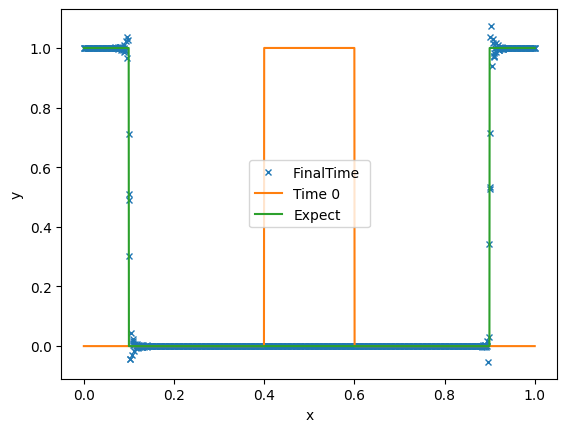

In [5]:

def f(x):
  x = np.divmod(x, 1)[1]
  # if 0.4 <= x <= 0.6:
  #   return 1
  # return 0
  return np.piecewise(x, [(x<0.4) & (x>0.6) , (0.4<=x) & (x<=0.6)], [0, 1])
# f = np.frompyfunc(fp, 1, 1)



# f = lambda x : np.sin(2 * np.pi * x) + np.cos(2 * np.pi * x)
finalTime = 0.5
advectionSpeed = 1
global N
N = 8
u = SolveAdvection(f, finalTime, advectionSpeed, plot = True)

In [18]:
class Config:
  M = 10
  K = 99
  N = 8
  NF = 15



import pandas as pd
class Generator:
  
  @staticmethod
  def getAdvectionSpeed():
    return np.random.uniform(0.5, 1)
  @staticmethod
  def getFinalTime():
    return np.random.uniform(0.1, 0.3)
  
  @staticmethod
  def numJumps():
    return np.random.randint(0, Config.M )
  @staticmethod
  def getDisconts(n):
    return np.unique(np.random.choice(Config.K + 1, n))
  @staticmethod
  def getSinFunc():
    data = [np.random.uniform(-1, 1) for i in range(Config.NF)]
    return lambda x : sum([data[n] * np.sin(n * x) for n in range(Config.NF)])
  @staticmethod
  def getCosFunc():
    data = [np.random.uniform(-1, 1) for i in range(Config.NF)]
    return lambda x : sum([ data[n] * np.cos(n * x) for n in range(Config.NF)])
  @staticmethod
  def getFunc(cosFList, sinFList, labels, x):
    x = np.divmod(x, 1)[1]
    h  = 1/(Config.K + 1)
    lst = []
    for i in range(len(labels) + 1):
      cosF = cosFList[i]
      sinF = sinFList[i]
      f = lambda x, cosF_ = cosF, sinF_= sinF : cosF_(x) + sinF_(x)
      lst.append(lambda x , fn = f: fn(x))
    if len(labels) == 0:
      return cosFList[0](x) + sinFList[0](x)
    if len(labels) == 1:
      return np.piecewise(x, [x < labels[0] * h, x>= labels[0] * h ], lst)
    return  np.piecewise(x, [x < labels[0] * h] + [(x< labels[i] * h )& (x>= labels[i - 1] * h) for i in range(1, len(labels))] + [x>= labels[- 1] * h ], lst)
  @staticmethod
  def getDiscontData():
    a = Generator.getAdvectionSpeed()
    finalTime = Generator.getFinalTime()
    numJumps = Generator.numJumps()
    labels = Generator.getDisconts(numJumps)
    labels = labels.sort()
    cosFList = [Generator.getCosFunc() for _ in range(len(labels) + 1)]
    sinFList = [Generator.getSinFunc() for _ in range(len(labels) + 1)] 
    

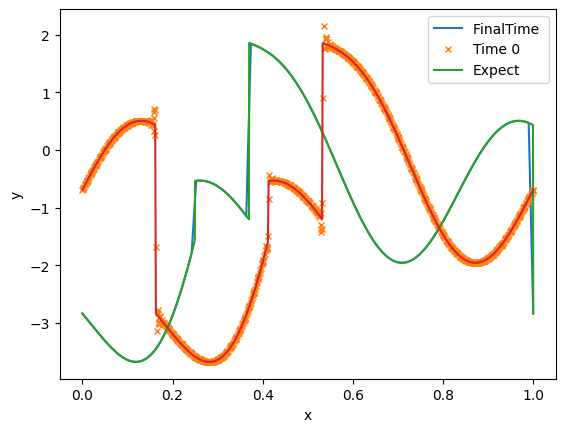

In [21]:
a = Generator.getAdvectionSpeed()
finalTime = Generator.getFinalTime()
numJumps = Generator.numJumps()
labels = Generator.getDisconts(numJumps)
# print(labels)
labels.sort()
cosFList = [Generator.getCosFunc() for _ in range(len(labels) + 1)]
sinFList = [Generator.getSinFunc() for _ in range(len(labels) + 1)] 
x = np.linspace(0, 1,100)
f = lambda x : Generator.getFunc(cosFList, sinFList, labels, x)
plt.plot(x, f(x))
u = SolveAdvection(f, finalTime, a, plot = True)
# plt.plot(x.ravel('F'), u.ravel('F'), 'x', markersize = 1)

In [22]:
from tqdm.notebook import tqdm
for i in tqdm(range(10000)):
  a = Generator.getAdvectionSpeed()
  finalTime = Generator.getFinalTime()
  numJumps = Generator.numJumps()
  labels = Generator.getDisconts(numJumps)
  # print(labels)
  labels.sort()
  cosFList = [Generator.getCosFunc() for _ in range(len(labels) + 1)]
  sinFList = [Generator.getSinFunc() for _ in range(len(labels) + 1)] 
  x = np.linspace(0, 1,100)
  f = lambda x : Generator.getFunc(cosFList, sinFList, labels, x)
  # plt.plot(x, f(x))

  # f = lambda x : np.sin(2 * np.pi * x) + np.cos(2 * np.pi * x)
  N = 8
  u = SolveAdvection(f, finalTime, a)
  if(u.max()>100):
    continue
  di = {'u' : u, 'labels' : labels , 'advectionSpeed' : a ,'finalTime' : finalTime }
  np.save('DG_1D_Data/' + str(i + 1) + '.npy', di)

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 